In [1]:
# Make the cells wider in the browser window
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import datetime
import pandas as pd
import numpy as np
from numba import jit
from time import time

import train as train_utils
import DataLoader as DL

from importlib import reload
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import waveglow_model as model

matplotlib.rc("figure", figsize=(16,3))
matplotlib.rc("lines", linewidth=2)
# matplotlib.rc("font", serif='Computer Modern Roman')
# matplotlib.rc("title", fontsize=18)

# # for auto-reloading extenrnal modules
# # see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
# %load_ext autoreload
# %autoreload 2

This notebook is originally copied from WindForecast notebook. In it, we fit a Gaussian Process to the wind data to sample from to get scenarios for MPC. First, we fit a single GP directly to the data. Then, we'll match the original paper and fit a GP to the seasonal baseline and another GP to the residual.

# Run setup

In [2]:
# Run a setup script which defines some functions and constants for the MPC problems and what not
from mpc_util_functions import *

***

In [10]:
# reload(train_utils)
# wg_model = model.WaveGlow(
#     n_context_channels=96, 
#     n_flows=8, 
#     n_group=48, 
#     n_early_every=99,
#     n_early_size=99,
#     n_layers=8,
#     dilation_list=[1,1,2,2,2,2,4,4],
#     n_channels=96,
#     kernel_size=3, use_cuda=False);

# wg_model, iteration_num = train_utils.load_checkpoint("CHECKPOINTS_FROM_GCLOUD/nctx-96_nflows-8_ngroup-48_nee-99_nes-99_nlayers-8_dilation-11222244_nchannels-96_kernel-3_lr-0.001/epoch-14_loss--0.0396", wg_model, None)


# This model got 1027 as the cost of gas power when still using the huge battery
reload(train_utils)
net = model.WaveGlow(
    n_context_channels=96, 
    n_flows=16, 
    n_group=96, 
    n_early_every=99,
    n_early_size=99,
    n_layers=4,
    dilation_list=[1,1,2,2],
    n_channels=96,
    kernel_size=9, use_cuda=False);
net, iteration_num = train_utils.load_checkpoint("CHECKPOINTS_FROM_GCLOUD/waveglow_ncontextchannels-96_nflows-16_ngroup-96-nearlyevery-99-nearlysize-99-nlayers-4_dilations-1-1-2-2_nchannels_96-kernelsize-9-lr-0.00100_seed-2019/epoch-25_loss-0.0571", net, None)

Channels:  96
Channels:  96
Channels:  96
Channels:  96
Channels:  96
Channels:  96
Channels:  96
Channels:  96
Channels:  96
Channels:  96
Channels:  96
Channels:  96
Channels:  96
Channels:  96
Channels:  96
Channels:  96
Loaded checkpoint 'CHECKPOINTS_FROM_GCLOUD/waveglow_ncontextchannels-96_nflows-16_ngroup-96-nearlyevery-99-nearlysize-99-nlayers-4_dilations-1-1-2-2_nchannels_96-kernelsize-9-lr-0.00100_seed-2019/epoch-25_loss-0.0571' (iteration 466)


# Sampling using WaveGlow

In [11]:
# def run_net_mpc(net, K):
#     '''
#     Run MPC using scenarios generated from the given WaveGlow model in net
#     K is the number of scenarios to use
#     '''
    
#     T_MPC = intervals_per_day

#     energy_stored = np.empty(T)
#     target_output_MPC, wind_power_available_MPC, initial_storage_MPC, final_storage_MPC, final_energy_price, MPC_network = \
#         make_network(T_MPC, K)

#     initial_storage_MPC.value = np.matrix(initial_storage)
#     final_storage_MPC.value = np.matrix(initial_storage)
#     final_energy_price.value = np.matrix(MPC_final_energy_price)


#     def make_forecasts(t):
#         '''
#         Populates the cvx parameters target_output.MPC and wind_power_available_MPC
#         target_output_MPC is always the same
#         wind_power_available_MPC.value is a matrix of shape (T,K), where T is the length of one forecast (96)
#         and K is the number of scenarios (specified outside of this function). Each column represents
#         one forecast scenario. The first scalar element of every forecast is p_wind[sim_start_time+t]
#         '''
#         target_output_MPC.value = np.tile(target_output[t:t+T_MPC], (K,1)).T

#         #### Logan's code ####
#         # First, create the context torch tensors to be used as context for the model
#         context = p_wind[(sim_start_time+t+1-T_MPC):(sim_start_time+t+1)].values
#         context = np.reshape(context, (1, -1, 1))
#         context = np.repeat(context, K, axis=0)
#         context = torch.FloatTensor(context)

#         # Now, generate forecasts using this context:
#         scenarios = net.generate(context).numpy()

#         # Take only the first 95 entries, make the first entry p_wind[sim_start_time+t] for all
#         scenarios = np.hstack((
#             np.matrix([p_wind[sim_start_time+t]]*K).T,
#             scenarios[:, :-1]
#         ))

#         # Max and min out the wind power
#         scenarios = np.maximum(wind_power_min, scenarios)
#         scenarios = np.minimum(wind_power_max, scenarios)
#         wind_power_available_MPC.value = scenarios.T


#     def implement(t):
#         energy_stored[t] = MPC_network.devices[2].energy.value[0,0]
#         initial_storage_MPC.value = np.matrix(energy_stored[t])

        
#     print("Results for K = ", K)
#     cost_MPC, MPC_results = \
#         run_mpc(MPC_network, T, make_forecasts, implement, verbose = False, solver='ECOS')

#     wind_gen, gas_gen, storage = MPC_network.devices[0:3]

#     print_and_plot_stats(wind_power_avail =  p_wind[sim_start_time:sim_end_time], 
#                          wind_power_used = -MPC_results.power[(wind_gen, 0)].flatten(), 
#                          gas_power = -MPC_results.power[(gas_gen,0)].flatten(), 
#                          output =  target_output[:T],
#                          cost = cost_MPC)


In [12]:
run_net_mpc(wg_model, 20)

  0%|          | 0/2976 [00:00<?, ?it/s]

Results for K =  20


100%|██████████| 2976/2976 [1:08:35<00:00,  1.38s/it]

(Values are daily averages.)

Energy sold:		192.00 MWh
Wind energy avail.:	202.36 MWh
Gas gener. output:	23.90 MWh
Wind energy used:	167.84 MWh
Wind energy lost:	34.52 MWh

Energy sold (at $80/MWh):    $15360.00
Cost of gas generated energy:  $1026.91


<a id="pres_mpc"></a>
# Presceint MPC

In [5]:
T_MPC = intervals_per_day

energy_stored = np.empty(T)

target_output_MPC, wind_power_available_MPC, \
initial_storage_MPC, final_storage_MPC, \
final_energy_price, MPC_network = \
    make_network(T_MPC, 1)
    
initial_storage_MPC.value = np.matrix(initial_storage)
final_storage_MPC.value = np.matrix(initial_storage)
final_energy_price.value = np.matrix(MPC_final_energy_price)

def make_forecasts(t):
    target_output_MPC.value = np.matrix(target_output[t:t+T_MPC]).T
    wind_power_available_MPC.value = np.matrix(p_wind[sim_start_time+t:sim_start_time+t+T_MPC]).T
    
def implement(t):
    energy_stored[t] = MPC_network.devices[2].energy.value[0]
    initial_storage_MPC.value = np.matrix(energy_stored[t])
    #final_storage_MPC.value = np.matrix(energy_stored[t]) # change this to change MPC behavior
    
cost_prescient_MPC, prescient_MPC_results = \
    run_mpc(MPC_network, T, make_forecasts, implement, verbose = False, solver='ECOS')

wind_gen, gas_gen, storage = MPC_network.devices[0:3]

print_and_plot_stats(wind_power_avail =  p_wind[sim_start_time:sim_end_time], 
                     wind_power_used = -prescient_MPC_results.power[(wind_gen, 0)].flatten(), 
                     gas_power = -prescient_MPC_results.power[(gas_gen,0)].flatten(), 
                     output =  target_output[:T],
                     cost = cost_prescient_MPC)

100%|██████████| 2976/2976 [01:54<00:00, 25.97it/s]

(Values are daily averages.)

Energy sold:		192.00 MWh
Wind energy avail.:	202.36 MWh
Gas gener. output:	25.04 MWh
Wind energy used:	167.81 MWh
Wind energy lost:	34.55 MWh

Energy sold (at $80/MWh):    $15360.00
Cost of gas generated energy:  $1044.48


<a id="mpc_no_scn"></a>
# MPC no scenarios (vanilla forecaster from paper) 

In [6]:
T_MPC = intervals_per_day

energy_stored = np.empty(T)

target_output_MPC, wind_power_available_MPC, initial_storage_MPC, final_storage_MPC, final_energy_price, MPC_network = \
    make_network(T_MPC, 1)
    
initial_storage_MPC.value = np.matrix(initial_storage)
final_storage_MPC.value = np.matrix(initial_storage)
final_energy_price.value = np.matrix(MPC_final_energy_price)

def predict_wind(p_wind, baseline, autoreg_residual_params, t, M, L, K = 1):
    past = p_wind[t-M:t]
    past_baseline = baseline[t-M:t]
    fut_baseline = baseline[t:t+L]
    pred = list(reversed(past-past_baseline)) @ autoreg_residual_params
    pred = pd.Series(pred, index=fut_baseline.index)
    pred += fut_baseline
    pred = np.maximum(wind_power_min, pred)
    pred = np.minimum(wind_power_max, pred)
    return pred

def make_forecasts(t):
    target_output_MPC.value = np.matrix(target_output[t:t+T_MPC]).T
    val_to_assign = np.matrix(np.concatenate([
        [p_wind[sim_start_time+t]],
        predict_wind(p_wind, baseline, autoreg_residual_params, sim_start_time+t+1, T_MPC, T_MPC)[:-1]])).T
        
#     print(type(val_to_assign))
#     print(val_to_assign.shape)
    wind_power_available_MPC.value = val_to_assign
        
def implement(t):
    energy_stored[t] = MPC_network.devices[2].energy.value[0]
    initial_storage_MPC.value = np.matrix(energy_stored[t])
    #final_storage_MPC.value = np.matrix(energy_stored[t]) # change this to change MPC behavior
    
cost_AR_MPC, AR_MPC_results = \
    run_mpc(MPC_network, T, make_forecasts, implement, verbose = False, solver='ECOS')

wind_gen, gas_gen, storage = MPC_network.devices[0:3]

print_and_plot_stats(wind_power_avail =  p_wind[sim_start_time:sim_end_time], 
                     wind_power_used = -AR_MPC_results.power[(wind_gen, 0)].flatten(), 
                     gas_power = -AR_MPC_results.power[(gas_gen,0)].flatten(), 
                     output =  target_output[:T],
                     cost = cost_AR_MPC,
                     plot_stuff = True)

100%|██████████| 2976/2976 [02:13<00:00, 22.33it/s]

(Values are daily averages.)

Energy sold:		192.00 MWh
Wind energy avail.:	202.36 MWh
Gas gener. output:	40.53 MWh
Wind energy used:	150.96 MWh
Wind energy lost:	51.40 MWh

Energy sold (at $80/MWh):    $15360.00
Cost of gas generated energy:  $1703.51


<a id="rmpc"></a>
# Robust MPC (from paper) 

In [3]:
T_MPC = intervals_per_day
K = 20 # Number of scenarios

energy_stored = np.empty(T)

target_output_MPC, wind_power_available_MPC, initial_storage_MPC, final_storage_MPC, final_energy_price, MPC_network = \
    make_network(T_MPC, K)
    
initial_storage_MPC.value = np.matrix(initial_storage)
final_storage_MPC.value = np.matrix(initial_storage)
final_energy_price.value = np.matrix(MPC_final_energy_price)


def make_forecasts(t):
    target_output_MPC.value = np.tile(target_output[t:t+T_MPC], (K,1)).T
#     wind_power_available_MPC.value = np.tile(np.concatenate([
#         [p_wind[sim_start_time+t]],
#         predict_wind(p_wind, baseline, autoreg_residual_params, sim_start_time+t+1, T_MPC, T_MPC)[:-1]]),
#                                              (K,1)).T
    # draw scenarios
    scenarios = np.hstack([np.matrix([p_wind[sim_start_time+t]]*K).T,
                           np.random.multivariate_normal(predict_wind(p_wind, baseline, 
                            autoreg_residual_params, sim_start_time+t+1, T_MPC, T_MPC), 
                             sigma_residual_errors, K)[:,:-1]])
    scenarios = np.maximum(wind_power_min, scenarios)
    scenarios = np.minimum(wind_power_max, scenarios)
    wind_power_available_MPC.value = scenarios.T
    
        
def implement(t):
    energy_stored[t] = MPC_network.devices[2].energy.value[0,0]
    initial_storage_MPC.value = np.matrix(energy_stored[t])
    

In [21]:
'''
scenarios: 
first row(?) is one scalar value of available wind power t steps from the start of simulation, repeated K times (K row vector)
for second part, sample from a normal distribution:
    - mean is the predicted wind
    - covariance is the learned covariance matrix
    - take only the first 95 values, since we are using the 1st value as from p_wind
    
Thus, each column in scenarios is T long, and there are K columns, one for each scenario





'''



(1, 20)

100%|██████████| 2976/2976 [27:57<00:00,  1.87it/s]   


(Values are daily averages.)

Energy sold:		192.00 MWh
Wind energy avail.:	202.36 MWh
Gas gener. output:	25.07 MWh
Wind energy used:	166.81 MWh
Wind energy lost:	35.54 MWh

Energy sold (at $80/MWh):    $15360.00
Cost of gas generated energy:  $1072.10


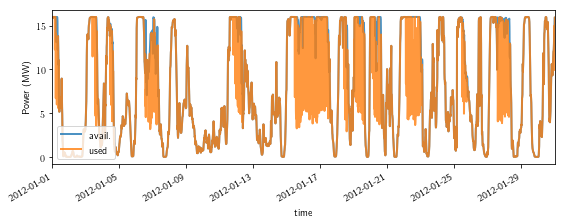

In [13]:
# Results done with K=20

cost_robust_MPC, MPC_robust_results = \
    run_mpc(MPC_network, T, make_forecasts, implement, verbose = False, solver='ECOS')

wind_gen, gas_gen, storage = MPC_network.devices[0:3]

print_and_plot_stats(wind_power_avail =  p_wind[sim_start_time:sim_end_time], 
                     wind_power_used = -MPC_robust_results.power[(wind_gen, 0)].flatten(), 
                     gas_power = -MPC_robust_results.power[(gas_gen,0)].flatten(), 
                     output =  target_output[:T],
                     cost = cost_robust_MPC,
                     plot_stuff = True)

***